In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import glob
import PIL
from PIL import Image
from torch.utils import data as D
from torch.utils.data.sampler import SubsetRandomSampler
import random

import torchsummary

print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.9.0+cu102
cuda:0


* 기존의 학습 데이터셋은 클래스 별 데이터셋의 개수가 꽤 균형있는 상태임

# 수정한 CIFAR 10 datasets (imbalanced)

In [3]:
from typing import Any, Callable, Optional, Tuple
from PIL import Image
import os
import os.path
import numpy as np
import pickle
from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
# custom dataset

class CIFAR10(VisionDataset):
    """`CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

    """
    base_folder = 'cifar-10-batches-py'
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    tgz_md5 = 'c58f30108f718f92721af3b95e74349a'
    train_list = [
        ['data_batch_1', 'c99cafc152244af753f735de768cd75f'],
        ['data_batch_2', 'd4bba439e000b95fd0a9bffe97cbabec'],
        ['data_batch_3', '54ebc095f3ab1f0389bbae665268c751'],
        ['data_batch_4', '634d18415352ddfa80567beed471001a'],
        ['data_batch_5', '482c414d41f54cd18b22e5b47cb7c3cb'],
    ]

    test_list = [
        ['test_batch', '40351d587109b95175f43aff81a1287e'],
    ]
    meta = {
        'filename': 'batches.meta',
        'key': 'label_names',
        'md5': '5ff9c542aee3614f3951f8cda6e48888',
    }

    def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,
            imbalanced: bool = False,
    ) -> None:

        super(CIFAR10, self).__init__(root, transform=transform,
                                      target_transform=target_transform)

        self.train = train  # training set or test set
        
        # 추가
        self.imbalanced = imbalanced
        
        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data: Any = []
        self.targets = []

        # now load the picked numpy arrays
        for file_name, checksum in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            with open(file_path, 'rb') as f:
                entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                if 'labels' in entry:
                    self.targets.extend(entry['labels'])
                else:
                    self.targets.extend(entry['fine_labels'])

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

        self._load_meta()
    
        ############################ imbalanced dataset ###############################
        if self.train and self.imbalanced:
            # print("total # of datasets:", len(self.targets))
            
            # 목표 : 리스트를 돌면서 1, 3, 5, 7, 9 번 클래스의 개수를 줄인다.
            # 방법 : 만약 리스트의 값이 1, 3, 5, 7, 9일 경우 각각 10번 중 9번 삭제
            remove_num = [1, 3, 5, 7, 9]
            remove_count = [0] * 5

            select_idx = [True] * (len(self.data))
            # print(select_idx)

            for i, target in enumerate(self.targets):
                if (target in remove_num) and i % 10 != 0:
                    idx = target // 2
                    remove_count[idx] += 1
                    select_idx[i] = False
                    
            self.data = self.data[select_idx]
            new_targets = []
            for i, val in enumerate(select_idx):
                if val:
                    new_targets.append(self.targets[i])
                
            self.targets = new_targets
        #############################################################################
        print("# of dataset: ", len(self.data))

    def _load_meta(self) -> None:
        path = os.path.join(self.root, self.base_folder, self.meta['filename'])
        if not check_integrity(path, self.meta['md5']):
            raise RuntimeError('Dataset metadata file not found or corrupted.' +
                               ' You can use download=True to download it')
        with open(path, 'rb') as infile:
            data = pickle.load(infile, encoding='latin1')
            self.classes = data[self.meta['key']]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


    def __len__(self) -> int:
        return len(self.data)

    def _check_integrity(self) -> bool:
        root = self.root
        for fentry in (self.train_list + self.test_list):
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self) -> None:
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        download_and_extract_archive(self.url, self.root, filename=self.filename, md5=self.tgz_md5)

    def extra_repr(self) -> str:
        return "Split: {}".format("Train" if self.train is True else "Test")

In [4]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

In [5]:
# imbalanced paramter를 추가해서 True로 주면 된다.
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform, imbalanced=True)
validset = CIFAR10(root='./data', train=True, download=True, transform=transform, imbalanced=True)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
# of dataset:  27467
Files already downloaded and verified
# of dataset:  27467
Files already downloaded and verified
# of dataset:  10000


In [6]:
batch_size = 64

In [7]:
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))

random_seed = 42
np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split] # train 90% valid 10%로 설정
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=0)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, sampler=valid_sampler, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

print("# of train set :", int(len(trainset) * 0.9))
print("# of valid set :", int(len(validset) * 0.1))
print("# of test set :", len(testset))

# of train set : 24720
# of valid set : 2746
# of test set : 10000


In [8]:
from collections import defaultdict

### 클래스 별 개수 확인하기 (training set)
print("\n\n-----------------------------------\n\n")

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_class = defaultdict(int)

for data in train_loader:
    _input, _label = data
    
    for i in _label:
        num_class[classes[i]] += 1
    
total = 0
for cls, num in num_class.items():
    total += num
    print(f"number of {cls} is", num)
    
print("\n\ntotal dataset :", total)
print("--------------------------")

num_class = defaultdict(int)
for data in test_loader:
    _input, _label = data
    
    for i in _label:
        num_class[classes[i]] += 1

total = 0
for cls, num in num_class.items():
    total += num
    print(f"number of {cls} is ", num)
print("\n\ntotal dataset :", total)



-----------------------------------


number of plane is 4501
number of ship is 4477
number of deer is 4542
number of frog is 4459
number of bird is 4510
number of car is 462
number of cat is 435
number of horse is 420
number of truck is 450
number of dog is 465


total dataset : 24721
--------------------------
number of cat is  1000
number of ship is  1000
number of plane is  1000
number of frog is  1000
number of car is  1000
number of truck is  1000
number of dog is  1000
number of horse is  1000
number of deer is  1000
number of bird is  1000


total dataset : 10000


# 손실함수(CrossEntropy) 직접 구현하기

In [9]:
from torch.nn.modules import Module
from typing import Callable, Optional
from torch import Tensor
import torch.nn.functional as nn

from torch.nn.modules.loss import _WeightedLoss


class CrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight: Optional[Tensor] = None, size_average=None, ignore_index: int = -100,
                 reduce=None, reduction: str = 'mean') -> None:
        super(CrossEntropyLoss, self).__init__(weight, size_average, reduce, reduction)
        # self.ignore_index = ignore_index

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        def crossEntropyError(input, target):
            delta = 1e-7
            softmax = torch.nn.Softmax(dim=1)
            input = softmax(input)
            target = F.one_hot(target, num_classes=10) # target을 원-핫 벡터로 바꾸어주어야 한다. (64, 10)
            return -0.1 * torch.sum(target*torch.log(input+delta))
        return crossEntropyError(input, target)


# Focal Loss 직접 구현하기

In [10]:
from torch.nn.modules import Module
from typing import Callable, Optional
from torch import Tensor
import torch.nn.functional as nn

from torch.nn.modules.loss import _WeightedLoss



class FocalLoss(Module):
    def __init__(self, gamma=2, alpha=0.1, size_average=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average
        self.softmax = torch.nn.Softmax(dim=1)
        
    def forward(self, input, target):
        def focalLoss(input, target):
            delta = 1e-7
            input = self.softmax(input)
            target = F.one_hot(target, num_classes=10)
            ce = -target* torch.log(input+delta)
            weight = (1 - input) ** self.gamma
            fl = ce * weight
            fl = torch.sum(fl) * self.alpha
            return fl
        return focalLoss(input, target)

# 직접 구현한 Focal Loss로 학습 돌려보기

In [11]:
from densenet import *

def DenseNetBC_100_12():
    return DenseNet(growth_rate=12, num_layers=100, theta=0.5, drop_rate=0.2, num_classes=10)

In [12]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.device("cuda:0"))

True
GeForce RTX 2080 SUPER
cuda:0


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

net = DenseNetBC_100_12()
net.to(device)

cuda:0


DenseNet(
  (dense_init): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dense_block_1): DenseBlock(
    (bottleneck_layer_0): bottleneck_layer(
      (conv_1x1): bn_relu_conv(
        (batch_norm): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (conv_3x3): bn_relu_conv(
        (batch_norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (bottleneck_layer_1): bottleneck_layer(
      (conv_1x1): bn_relu_conv(
        (batch_norm): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
   

In [14]:
import torch.optim as optim

# criterion = CrossEntropyLoss()
criterion = FocalLoss(alpha=0.1, gamma=3)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 30 epoch만 돌고 test 해보기

* 1. CE를 사용하여 학습하여 best_model을 cifar_net_imbalanced_CE.pth 로 저장한다.
* 2. FL를 사용하여 학습하여 best_model을 cifar_net_imbalanced_FL.path로 저장한다.

101it [00:13,  8.02it/s]

[1,   100] loss: 6.244209


201it [00:25,  8.32it/s]

[1,   200] loss: 4.882556


301it [00:37,  8.43it/s]

[1,   300] loss: 4.481242


387it [00:48,  7.97it/s]
43it [00:01, 23.46it/s]
1it [00:00,  6.23it/s]

model saved
[1 epoch] Accuracy of the network on the validation images: 50 %
best at 1epoch


101it [00:12,  8.44it/s]

[2,   100] loss: 3.969446


201it [00:24,  8.39it/s]

[2,   200] loss: 3.755876


301it [00:36,  8.46it/s]

[2,   300] loss: 3.552696


387it [00:46,  8.38it/s]
43it [00:01, 24.70it/s]
1it [00:00,  7.30it/s]

model saved
[2 epoch] Accuracy of the network on the validation images: 59 %
best at 2epoch


101it [00:12,  8.40it/s]

[3,   100] loss: 3.153181


201it [00:24,  8.44it/s]

[3,   200] loss: 3.049306


301it [00:35,  8.41it/s]

[3,   300] loss: 2.943657


387it [00:46,  8.39it/s]
43it [00:01, 25.07it/s]
1it [00:00,  7.30it/s]

model saved
[3 epoch] Accuracy of the network on the validation images: 67 %
best at 3epoch


101it [00:12,  8.42it/s]

[4,   100] loss: 2.703137


201it [00:23,  8.56it/s]

[4,   200] loss: 2.630320


301it [00:35,  8.42it/s]

[4,   300] loss: 2.594398


387it [00:46,  8.40it/s]
43it [00:01, 25.09it/s]
1it [00:00,  6.17it/s]

model saved
[4 epoch] Accuracy of the network on the validation images: 67 %
best at 4epoch


101it [00:12,  8.42it/s]

[5,   100] loss: 2.401752


201it [00:23,  8.46it/s]

[5,   200] loss: 2.318091


301it [00:35,  8.43it/s]

[5,   300] loss: 2.177737


387it [00:45,  8.42it/s]
43it [00:01, 25.03it/s]
1it [00:00,  7.40it/s]

model saved
[5 epoch] Accuracy of the network on the validation images: 68 %
best at 5epoch


101it [00:12,  8.45it/s]

[6,   100] loss: 2.149215


201it [00:24,  8.34it/s]

[6,   200] loss: 2.071226


301it [00:35,  8.43it/s]

[6,   300] loss: 1.999212


387it [00:46,  8.39it/s]
43it [00:01, 25.03it/s]
1it [00:00,  7.23it/s]

model saved
[6 epoch] Accuracy of the network on the validation images: 70 %
best at 6epoch


101it [00:12,  8.43it/s]

[7,   100] loss: 1.885895


201it [00:23,  8.44it/s]

[7,   200] loss: 1.858661


301it [00:35,  8.41it/s]

[7,   300] loss: 1.803828


387it [00:45,  8.42it/s]
43it [00:01, 24.91it/s]
1it [00:00,  6.20it/s]

model saved
[7 epoch] Accuracy of the network on the validation images: 72 %
best at 7epoch


101it [00:12,  8.45it/s]

[8,   100] loss: 1.659411


201it [00:23,  8.43it/s]

[8,   200] loss: 1.766053


301it [00:35,  8.44it/s]

[8,   300] loss: 1.713484


387it [00:45,  8.42it/s]
43it [00:01, 25.07it/s]
1it [00:00,  7.28it/s]

model saved
[8 epoch] Accuracy of the network on the validation images: 75 %
best at 8epoch


101it [00:12,  8.37it/s]

[9,   100] loss: 1.515993


201it [00:23,  8.39it/s]

[9,   200] loss: 1.534758


301it [00:35,  8.44it/s]

[9,   300] loss: 1.624185


387it [00:45,  8.42it/s]
43it [00:01, 25.03it/s]
1it [00:00,  7.35it/s]

model saved
[9 epoch] Accuracy of the network on the validation images: 77 %
best at 9epoch


101it [00:12,  8.46it/s]

[10,   100] loss: 1.394664


201it [00:23,  8.40it/s]

[10,   200] loss: 1.473050


301it [00:35,  8.30it/s]

[10,   300] loss: 1.468419


387it [00:45,  8.42it/s]
43it [00:01, 25.03it/s]
1it [00:00,  6.81it/s]

[10 epoch] Accuracy of the network on the validation images: 77 %
best at 9epoch


101it [00:12,  8.43it/s]

[11,   100] loss: 1.255918


201it [00:23,  8.43it/s]

[11,   200] loss: 1.375932


301it [00:35,  8.40it/s]

[11,   300] loss: 1.387088


387it [00:46,  8.41it/s]
43it [00:01, 25.05it/s]
1it [00:00,  7.36it/s]

[11 epoch] Accuracy of the network on the validation images: 76 %
best at 9epoch


101it [00:12,  8.33it/s]

[12,   100] loss: 1.131557


201it [00:23,  8.45it/s]

[12,   200] loss: 1.176889


301it [00:35,  8.44it/s]

[12,   300] loss: 1.238198


387it [00:45,  8.42it/s]
43it [00:01, 25.00it/s]
1it [00:00,  7.37it/s]

model saved
[12 epoch] Accuracy of the network on the validation images: 79 %
best at 12epoch


101it [00:12,  8.43it/s]

[13,   100] loss: 1.067477


201it [00:23,  8.46it/s]

[13,   200] loss: 1.076218


301it [00:35,  8.54it/s]

[13,   300] loss: 1.089245


387it [00:45,  8.42it/s]
43it [00:01, 24.92it/s]
1it [00:00,  6.67it/s]

[13 epoch] Accuracy of the network on the validation images: 78 %
best at 12epoch


101it [00:12,  8.58it/s]

[14,   100] loss: 1.087828


201it [00:24,  8.32it/s]

[14,   200] loss: 0.984299


301it [00:35,  8.23it/s]

[14,   300] loss: 1.074105


387it [00:46,  8.39it/s]
43it [00:01, 25.02it/s]
1it [00:00,  7.20it/s]

[14 epoch] Accuracy of the network on the validation images: 79 %
best at 12epoch


101it [00:12,  8.42it/s]

[15,   100] loss: 0.924886


201it [00:23,  8.49it/s]

[15,   200] loss: 0.891654


301it [00:35,  8.54it/s]

[15,   300] loss: 0.898451


387it [00:45,  8.42it/s]
43it [00:01, 24.85it/s]
1it [00:00,  8.09it/s]

model saved
[15 epoch] Accuracy of the network on the validation images: 81 %
best at 15epoch


101it [00:12,  8.52it/s]

[16,   100] loss: 0.800796


201it [00:23,  8.46it/s]

[16,   200] loss: 0.900947


301it [00:35,  8.24it/s]

[16,   300] loss: 0.883961


387it [00:45,  8.41it/s]
43it [00:01, 24.42it/s]
1it [00:00,  5.89it/s]

[16 epoch] Accuracy of the network on the validation images: 80 %
best at 15epoch


101it [00:11,  8.49it/s]

[17,   100] loss: 0.780412


201it [00:22,  8.84it/s]

[17,   200] loss: 0.751868


301it [00:34,  8.88it/s]

[17,   300] loss: 0.788886


387it [00:43,  8.81it/s]
43it [00:01, 25.65it/s]
1it [00:00,  7.57it/s]

[17 epoch] Accuracy of the network on the validation images: 80 %
best at 15epoch


101it [00:11,  8.74it/s]

[18,   100] loss: 0.681429


201it [00:22,  8.78it/s]

[18,   200] loss: 0.676332


301it [00:34,  8.85it/s]

[18,   300] loss: 0.703977


387it [00:43,  8.83it/s]
43it [00:01, 25.62it/s]
1it [00:00,  7.58it/s]

model saved
[18 epoch] Accuracy of the network on the validation images: 81 %
best at 18epoch


101it [00:11,  8.83it/s]

[19,   100] loss: 0.626695


201it [00:22,  8.83it/s]

[19,   200] loss: 0.652852


301it [00:34,  8.83it/s]

[19,   300] loss: 0.660757


387it [00:43,  8.83it/s]
43it [00:01, 25.55it/s]
1it [00:00,  6.25it/s]

model saved
[19 epoch] Accuracy of the network on the validation images: 81 %
best at 19epoch


101it [00:11,  8.84it/s]

[20,   100] loss: 0.573365


201it [00:22,  8.84it/s]

[20,   200] loss: 0.681166


301it [00:34,  8.85it/s]

[20,   300] loss: 0.610154


387it [00:43,  8.82it/s]
43it [00:01, 25.65it/s]
1it [00:00,  7.33it/s]

[20 epoch] Accuracy of the network on the validation images: 80 %
best at 19epoch


101it [00:11,  8.85it/s]

[21,   100] loss: 0.520393


201it [00:22,  8.82it/s]

[21,   200] loss: 0.586088


301it [00:34,  8.84it/s]

[21,   300] loss: 0.609614


387it [00:43,  8.83it/s]
43it [00:01, 25.55it/s]
1it [00:00,  7.62it/s]

[21 epoch] Accuracy of the network on the validation images: 81 %
best at 19epoch


101it [00:11,  8.82it/s]

[22,   100] loss: 0.465367


201it [00:22,  8.79it/s]

[22,   200] loss: 0.550987


301it [00:34,  8.85it/s]

[22,   300] loss: 0.573560


387it [00:43,  8.82it/s]
43it [00:01, 25.57it/s]
1it [00:00,  7.72it/s]

model saved
[22 epoch] Accuracy of the network on the validation images: 82 %
best at 22epoch


101it [00:11,  8.81it/s]

[23,   100] loss: 0.439773


201it [00:22,  9.02it/s]

[23,   200] loss: 0.475490


301it [00:34,  8.80it/s]

[23,   300] loss: 0.488963


387it [00:43,  8.80it/s]
43it [00:01, 25.10it/s]
1it [00:00,  7.61it/s]

model saved
[23 epoch] Accuracy of the network on the validation images: 82 %
best at 23epoch


101it [00:11,  8.88it/s]

[24,   100] loss: 0.429822


201it [00:22,  8.76it/s]

[24,   200] loss: 0.410996


301it [00:34,  8.77it/s]

[24,   300] loss: 0.497384


387it [00:43,  8.81it/s]
43it [00:01, 25.62it/s]
1it [00:00,  8.44it/s]

[24 epoch] Accuracy of the network on the validation images: 82 %
best at 23epoch


101it [00:11,  9.00it/s]

[25,   100] loss: 0.520616


201it [00:22,  8.77it/s]

[25,   200] loss: 0.444433


301it [00:34,  8.85it/s]

[25,   300] loss: 0.435069


387it [00:43,  8.81it/s]
43it [00:01, 25.56it/s]
1it [00:00,  7.55it/s]

model saved
[25 epoch] Accuracy of the network on the validation images: 83 %
best at 25epoch


101it [00:11,  8.77it/s]

[26,   100] loss: 0.357293


201it [00:22,  8.86it/s]

[26,   200] loss: 0.394742


301it [00:34,  8.62it/s]

[26,   300] loss: 0.370848


387it [00:43,  8.82it/s]
43it [00:01, 25.60it/s]
1it [00:00,  6.29it/s]

[26 epoch] Accuracy of the network on the validation images: 82 %
best at 25epoch


101it [00:11,  8.91it/s]

[27,   100] loss: 0.315464


201it [00:22,  8.78it/s]

[27,   200] loss: 0.348765


301it [00:34,  8.97it/s]

[27,   300] loss: 0.430020


387it [00:43,  8.80it/s]
43it [00:01, 25.66it/s]
1it [00:00,  7.70it/s]

[27 epoch] Accuracy of the network on the validation images: 82 %
best at 25epoch


101it [00:11,  8.83it/s]

[28,   100] loss: 0.354665


201it [00:22,  8.84it/s]

[28,   200] loss: 0.298846


301it [00:34,  8.79it/s]

[28,   300] loss: 0.377996


387it [00:43,  8.83it/s]
43it [00:01, 25.58it/s]
1it [00:00,  7.61it/s]

model saved
[28 epoch] Accuracy of the network on the validation images: 83 %
best at 28epoch


101it [00:11,  8.86it/s]

[29,   100] loss: 0.268088


201it [00:22,  8.80it/s]

[29,   200] loss: 0.266352


301it [00:34,  8.78it/s]

[29,   300] loss: 0.335705


387it [00:43,  8.83it/s]
43it [00:01, 25.53it/s]
1it [00:00,  6.33it/s]

model saved
[29 epoch] Accuracy of the network on the validation images: 83 %
best at 29epoch


101it [00:11,  8.87it/s]

[30,   100] loss: 0.285053


201it [00:22,  8.86it/s]

[30,   200] loss: 0.296396


301it [00:34,  8.86it/s]

[30,   300] loss: 0.298741


387it [00:43,  8.82it/s]
43it [00:01, 25.58it/s]


model saved
[30 epoch] Accuracy of the network on the validation images: 84 %
best at 30epoch
학습 끝






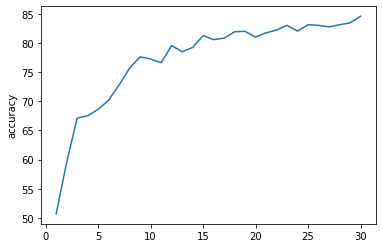

In [14]:
import gc
gc.collect()

from tqdm import tqdm
import matplotlib.pyplot as plt

loss_list = []
best_accuracy = 0
best_epoch = 0
accuracy_list = []
for epoch in range(30):
    
    running_loss = 0.0
    
    for i, data in tqdm(enumerate(train_loader, 0)):
        #print(i)
        #print(len(train_loader))
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # gradient 매개변수를 0으로 만든다.
        optimizer.zero_grad()
        
        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        # print("loss:", loss)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 99:
            print('[%d, %5d] loss: %3f' % (epoch + 1, i + 1, running_loss / 100))
            loss_list.append(running_loss / 100)
            running_loss = 0.0
            
    # validation part
    # validation 과정에서는 balanced dataset을 활용하는 것이 좋을듯! test_laoder 사용
    correct = 0
    total = 0
    for i, data in tqdm(enumerate(valid_loader, 0)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    # best model을 저장하도록 설정
    if best_accuracy <= (100. * correct / total):
        best_epoch = epoch + 1
        best_accuracy = (100 * correct / total)
        PATH = './cifar_net_imbalanced_FL3.pth'
        torch.save(net.state_dict(), PATH)
        print("model saved")
        
    print('[%d epoch] Accuracy of the network on the validation images: %d %%' % 
          (epoch + 1, 100 * correct / total))
    accuracy_list.append(100 * correct / total)
    
    print('best at {}epoch'.format(best_epoch))
    
    

print("학습 끝")
print("\n\n\n")
plt.plot([i for i in range(1, 31)], accuracy_list)
plt.ylabel("accuracy")
plt.show()

# 모델 저장하기

In [15]:
CE_PATH = './cifar_net_imbalanced_CE2.pth'
FL_PATH = './cifar_net_imbalanced_FL3.pth'
# torch.save(net.state_dict(), FL_PATH)

# test (Focal Loss)

In [16]:
from tqdm import tqdm

# 모델 불러오기
net = DenseNetBC_100_12()
net.load_state_dict(torch.load(FL_PATH))
net.to(device)
print("load 완료")
total = 0
correct = 0

for i, data in tqdm(enumerate(test_loader, 0)): # 10000장의 balanced data
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
print(100 * (correct / total))

0it [00:00, ?it/s]

load 완료


1it [00:03,  3.43s/it]


RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 8.00 GiB total capacity; 2.44 GiB already allocated; 0 bytes free; 2.52 GiB reserved in total by PyTorch)

# test (Cross Loss)

In [17]:
from tqdm import tqdm

# 모델 불러오기
net = DenseNetBC_100_12()
net.load_state_dict(torch.load(CE_PATH))
net.to(device)
print("load 완료")
total = 0
correct = 0

for i, data in tqdm(enumerate(test_loader, 0)): # 10000장의 balanced data
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
print(100 * (correct / total))

3it [00:00, 22.44it/s]

load 완료


157it [00:06, 24.91it/s]

63.480000000000004


In [1]:
# 각 분류에 대한 예측값 계산
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

correct_pred = {classname : 0 for classname in classes}
total_pred = {classname : 0 for classname in classes}

# 변화도는 test중이므로 필요하지 않음

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        
        # 각 분류별로 올바른 예측 수를 모읍니다.
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            
    
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

NameError: name 'torch' is not defined